### Empirical Asset Pricing with ML

Fabio Ceruti

Fabio Martino

Jacopo Biggiogera

In [16]:
#Imports
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
import warnings
from skopt import BayesSearchCV
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Bidirectional
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers import Activation
from collections import Counter
from cProfile import label

In [17]:
#Reading in the data
prices = pd.read_csv("Data_PCLab4_Stock_Price.csv")
volumes = pd.read_csv("Data_PCLab4_Stock_Volume.csv")

## Basic manipulation and descriptive statistics

In [18]:
# Describing the data
print('Describing the dataset')
print('')
#Sorting by date
prices = prices.sort_values(by = 'Date')
volumes = volumes.sort_values(by = 'Date')

#Print number of stocks
print(f'Number of stocks: {len(prices.columns)-1}')
print('')

#Checking for Null Values
print(f'Are any null values present in prices: {prices.isnull().values.any()}')
print(f'Are any null values present in volumes: {volumes.isnull().values.any()}')
print('')

#Finding S&P average market value
print(f'Average market value of S&P500: {round(np.mean(prices.iloc[:,-1]), 3)}')
print('')
#Finding stock with minimum dispersion
index = np.argmin(np.std(np.array(prices.iloc[:, 1:]), axis = 0)) + 1 #Adding 1 since indexes are shifted by the Date column

print(f'Stock with lowest dispersion: {prices.columns[index]} (using std as dispersion measure)')
print('')

#Average trading volume of Apple
print(f"Average trading volume of Apple: {round(np.mean(volumes['AAPL']), 3)}")
print('')

#Maximum trading volume of SP500
print(f"Maximum trading volume of SP500: {np.max(volumes['sp500'])}")
print('')

#Security that is traded the most

maxes = [(np.max(volumes[i]), i) for i in volumes.columns[1:]]
trades = 0
top_traded = 'name'
for m, name in maxes:
    if m>trades:
        trades = m
        top_traded = name
print(f"Most traded stock: {top_traded}")

Describing the dataset

Number of stocks: 9

Are any null values present in prices: False
Are any null values present in volumes: False

Average market value of S&P500: 2218.75

Stock with lowest dispersion: T (using std as dispersion measure)

Average trading volume of Apple: 58203317.415

Maximum trading volume of SP500: 9044690000

Most traded stock: sp500


In [19]:
#Normalizing the stock prices and volumes
normalized_prices=prices.iloc[:, 1:]/prices.iloc[0, 1:]
normalized_volumes=volumes.iloc[:, 1:]/volumes.iloc[0, 1:]
normalized_prices['Date'] = prices.loc[:,'Date']
normalized_volumes['Date'] = prices.loc[:,'Date']

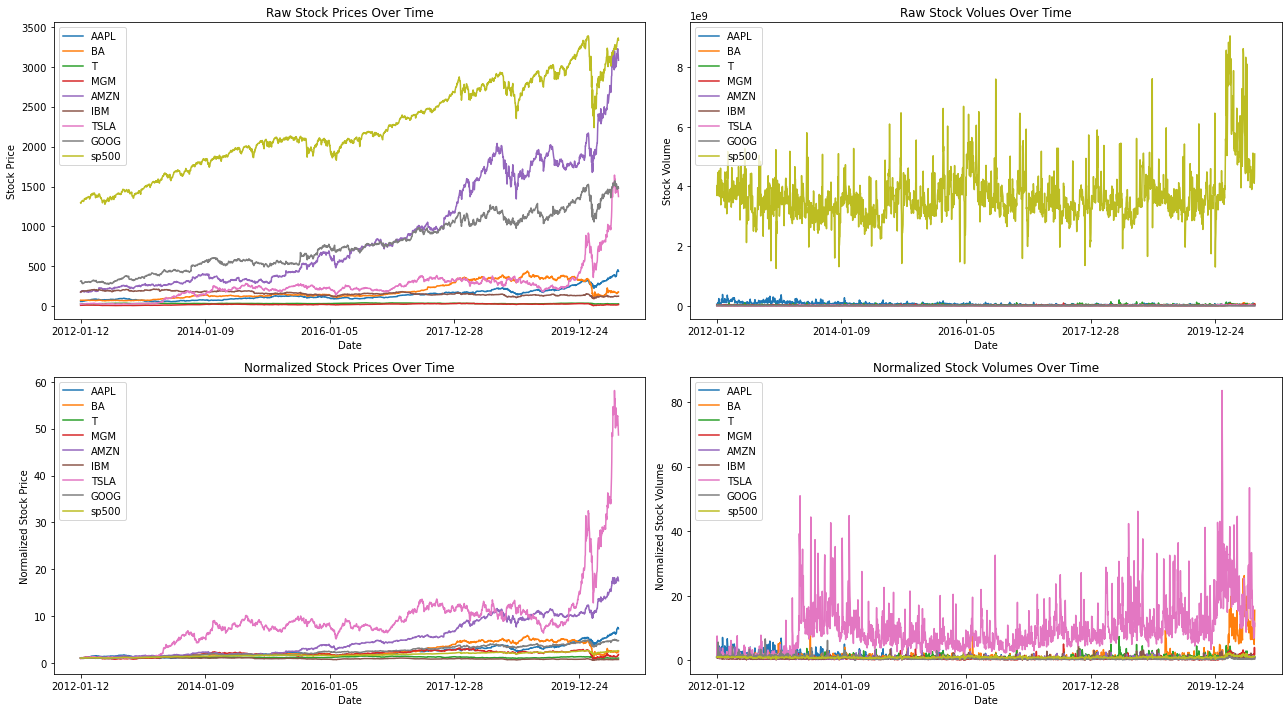

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,10))
ax=axs[0,0]
ax.set_title('Raw Stock Prices Over Time')
prices.plot('Date', prices.columns[1:], ax = ax)
ax.set_ylabel('Stock Price')

ax =axs[0,1]
ax.set_title('Raw Stock Volues Over Time')
volumes.plot('Date', volumes.columns[1:], ax = ax)
ax.set_ylabel('Stock Volume')

ax = axs[1,0]
ax.set_title('Normalized Stock Prices Over Time')
normalized_prices.plot('Date', normalized_prices.columns[:-1], ax = ax)
ax.set_ylabel('Normalized Stock Price')

ax=axs[1,1]
ax.set_title('Normalized Stock Volumes Over Time')
normalized_volumes.plot('Date', normalized_volumes.columns[:-1], ax = ax)
ax.set_ylabel('Normalized Stock Volume')

plt.tight_layout()
plt.show()

Consistent with the descriptive data presented earlier, it is possible to see the enormously larger amounts of trade volume and prices of the sp500, a fact that is consistent with the nature of this stock that represents a large part of the overall market. In fact, since the S&P 500 is composed by 500 stocks, it encapsulates the entirety of the transactions carried out for each of the ticker firms. It is interesting to see how in the normalised prices Amazon has a period of very high prices compared to all the other stock. This is indeed during the covid period where business for this company was booming a lot more than for oher companies. Similarly, TSLA since 2014 exhibits extraordinary growth both in terms of stock value and in number of normalized transactions carried out on a daily basis. In fact, TSLA was a relatively young firm in the market (it became public in 2010) making it that the denominator in terms of stock price and volume traded in 2012 is quite low compared to the growth it has experienced.

In [21]:
def daily_returns(data):
    '''This function calculates daily stock returns for a passed dataframe
    
    input: dataframe
    returns: dataframe of daily returns'''
    
    #generating copy of passed dateframe (avoid inplace modification)
    data1 = data.copy()
    
    #looping
    for s in data.columns:
        if s!='Date':
            for i in range(len(data.loc[:, s])):
                if i ==0:
                    continue
                else:
                    data1.loc[i, s] = (data.loc[i, s]/data.loc[i-1, s])-1
    return data1[1:]

def heatmap(df, title):
    '''this function plots a correaltion heatmap.
    inputs: dataframe of returns, title of plot
    returns: nothing'''
    plt.figure(figsize=(15,15))

    #generate heatmap froom the correlation table
    sn.heatmap(df.corr(), annot=True, cmap='Greens')
    plt.title(title)
    plt.show()

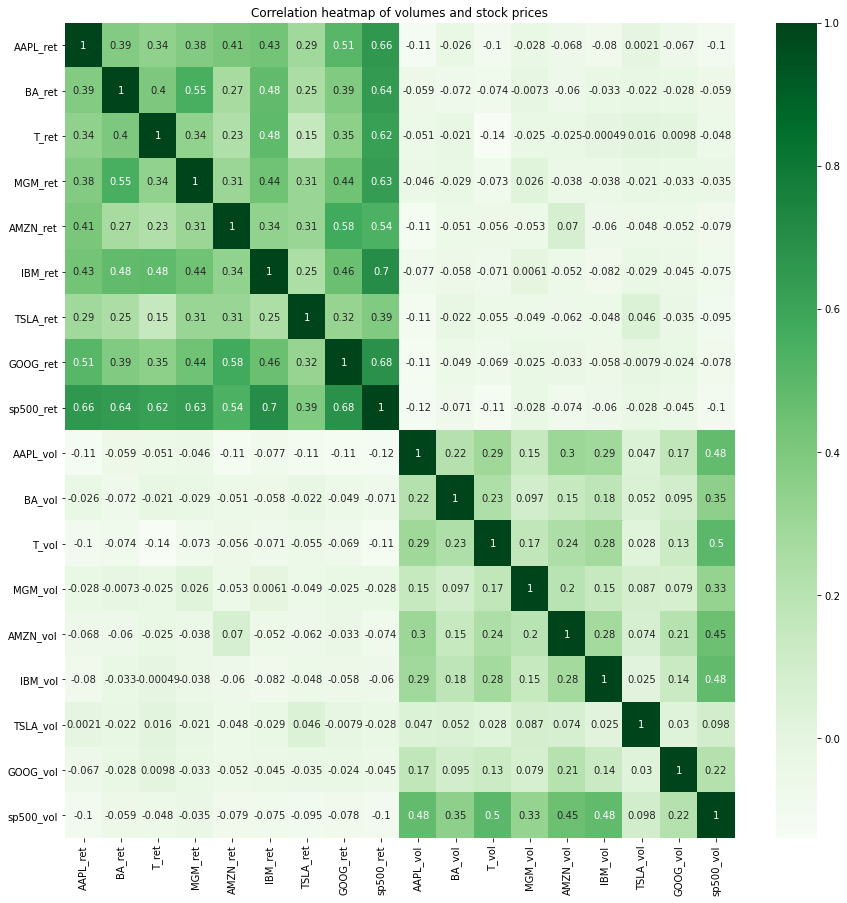

In [22]:
returns = daily_returns(prices)
volume_changes = daily_returns(volumes)
changes_all = returns.merge(volume_changes, 'outer', left_on = 'Date', right_on='Date', suffixes=('_ret', '_vol'))
heatmap(changes_all, 'Correlation heatmap of volumes and stock prices')


There does not seem to be a particularly meaningful correlation between changes in prices and changes in volumes. Indeed, if any there are only weak negative correlation between the two. This could be due to the large variance present in both volumes returns generated by considering such a long time frame. On the other hand, there are predominantly positive correlations between changes in volumes of different stocks and likewise changes in returns. This is particularly evident with correlations between any of these companies and the sp500, explained by the fact that these companies are all part of the sp500, and with correlations amongst companies that are in connected by operating in similar sectors, such as the technology sector in the case of google and amazon.

## Train and Test samples + Ridge regression

In [23]:
#Merging volumes and prices
data_absolute = pd.merge(prices, volumes, on='Date', suffixes=('_ret', '_vol'))
data_absolute.head(2)

,Date,AAPL_ret,BA_ret,T_ret,MGM_ret,AMZN_ret,IBM_ret,TSLA_ret,GOOG_ret,sp500_ret,AAPL_vol,BA_vol,T_vol,MGM_vol,AMZN_vol,IBM_vol,TSLA_vol,GOOG_vol,sp500_vol
0,2012-01-12,60.198570,75.510002,30.120001,12.13,175.929993,180.550003,28.250000,313.644379,1295.500000,53146800,3934500,26511100,17891100,5385800,6881000,729300,3764400,4019890000
1,2012-01-13,59.972858,74.599998,30.070000,12.35,178.419998,179.160004,22.790001,311.328064,1289.089966,56505400,4641100,22096800,16621800,4753500,5279200,5500400,4631800,3692370000


In [24]:
#Splitting in train and test
train = data_absolute.iloc[:int(len(data_absolute)*0.75), :]
test = data_absolute.iloc[int(len(data_absolute)*0.75):, :]
#Scaling data
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train.iloc[:, 1:])
test_scaled =sc.fit_transform(test.iloc[:, 1:])
#Extracting lagged response
y_train = train_scaled[1:, :9]
y_test = test_scaled[1:, :9]
train_scaled=train_scaled[:-1,:]
test_scaled=test_scaled[:-1,:]

In [10]:
def Roos(y_true, preds):
    '''This function calculates the out of sample R-squared
    input: true values, predictions

    returns:roos
    '''
    return 1 - (np.sum((preds- y_true)**2)/(np.sum(y_true**2)))

def Sign_check(y_true, preds):
    '''This function computes a sign check accuracy measures
    input: true values, predictions
    returns: fractions of true values and preds with the same sign'''
    checks=preds*y_true
    return len(checks[checks>0])/len(preds)

In [11]:
#OLS Regressions
linear_predictions = []
roos_linear=[]
fraction_checks_linear=[]
for i in range(8): #Running a linear regression for the 8 stocks in the dataset
    linear=Ridge(alpha=0)
    linear.fit(train_scaled[:,[i, i+9]], y_train[:,i])
    preds=linear.predict(test_scaled[:,[i,i+9]])
    linear_predictions.append(preds)
    roos_linear.append(Roos(y_test[:,i], preds))
    fraction_checks_linear.append(Sign_check(y_test[:,i], preds))

In [12]:
#Ridge Regressions
warnings.filterwarnings("ignore")
ridge_preds = []
roos_ridge=[]
fraction_checks_ridge=[]
alphas=[]
for i in tqdm(range(9)):
    #For each stock we are identifying the optimal alpha level for the 2 available regressors: previous price and volume
    n_iter = 20
    param_dist = {"alpha": np.arange(0, 100, 0.002)}
    mod= Ridge()
    #We decided to use Bayesian optimization to identify the optimal alpha as it is better suited 
    #for identifying the optimal value for a continuous variable
    search = BayesSearchCV(mod,
                    search_spaces=param_dist,
                    n_iter=n_iter,
                    cv=5, #5 folds cross validation to optimize alpha for each stock
                    n_jobs=-1)
    
    search.fit(train_scaled[:,[i, i+9]], y_train[:,i])
    preds=search.predict(test_scaled[:,[i,i+9]])
    ridge_preds.append(preds)
    roos_ridge.append(Roos(y_test[:,i], preds))
    fraction_checks_ridge.append(Sign_check(y_test[:,i], preds))
    alphas.append(search.best_params_['alpha'])

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:27<00:00, 23.09s/it]


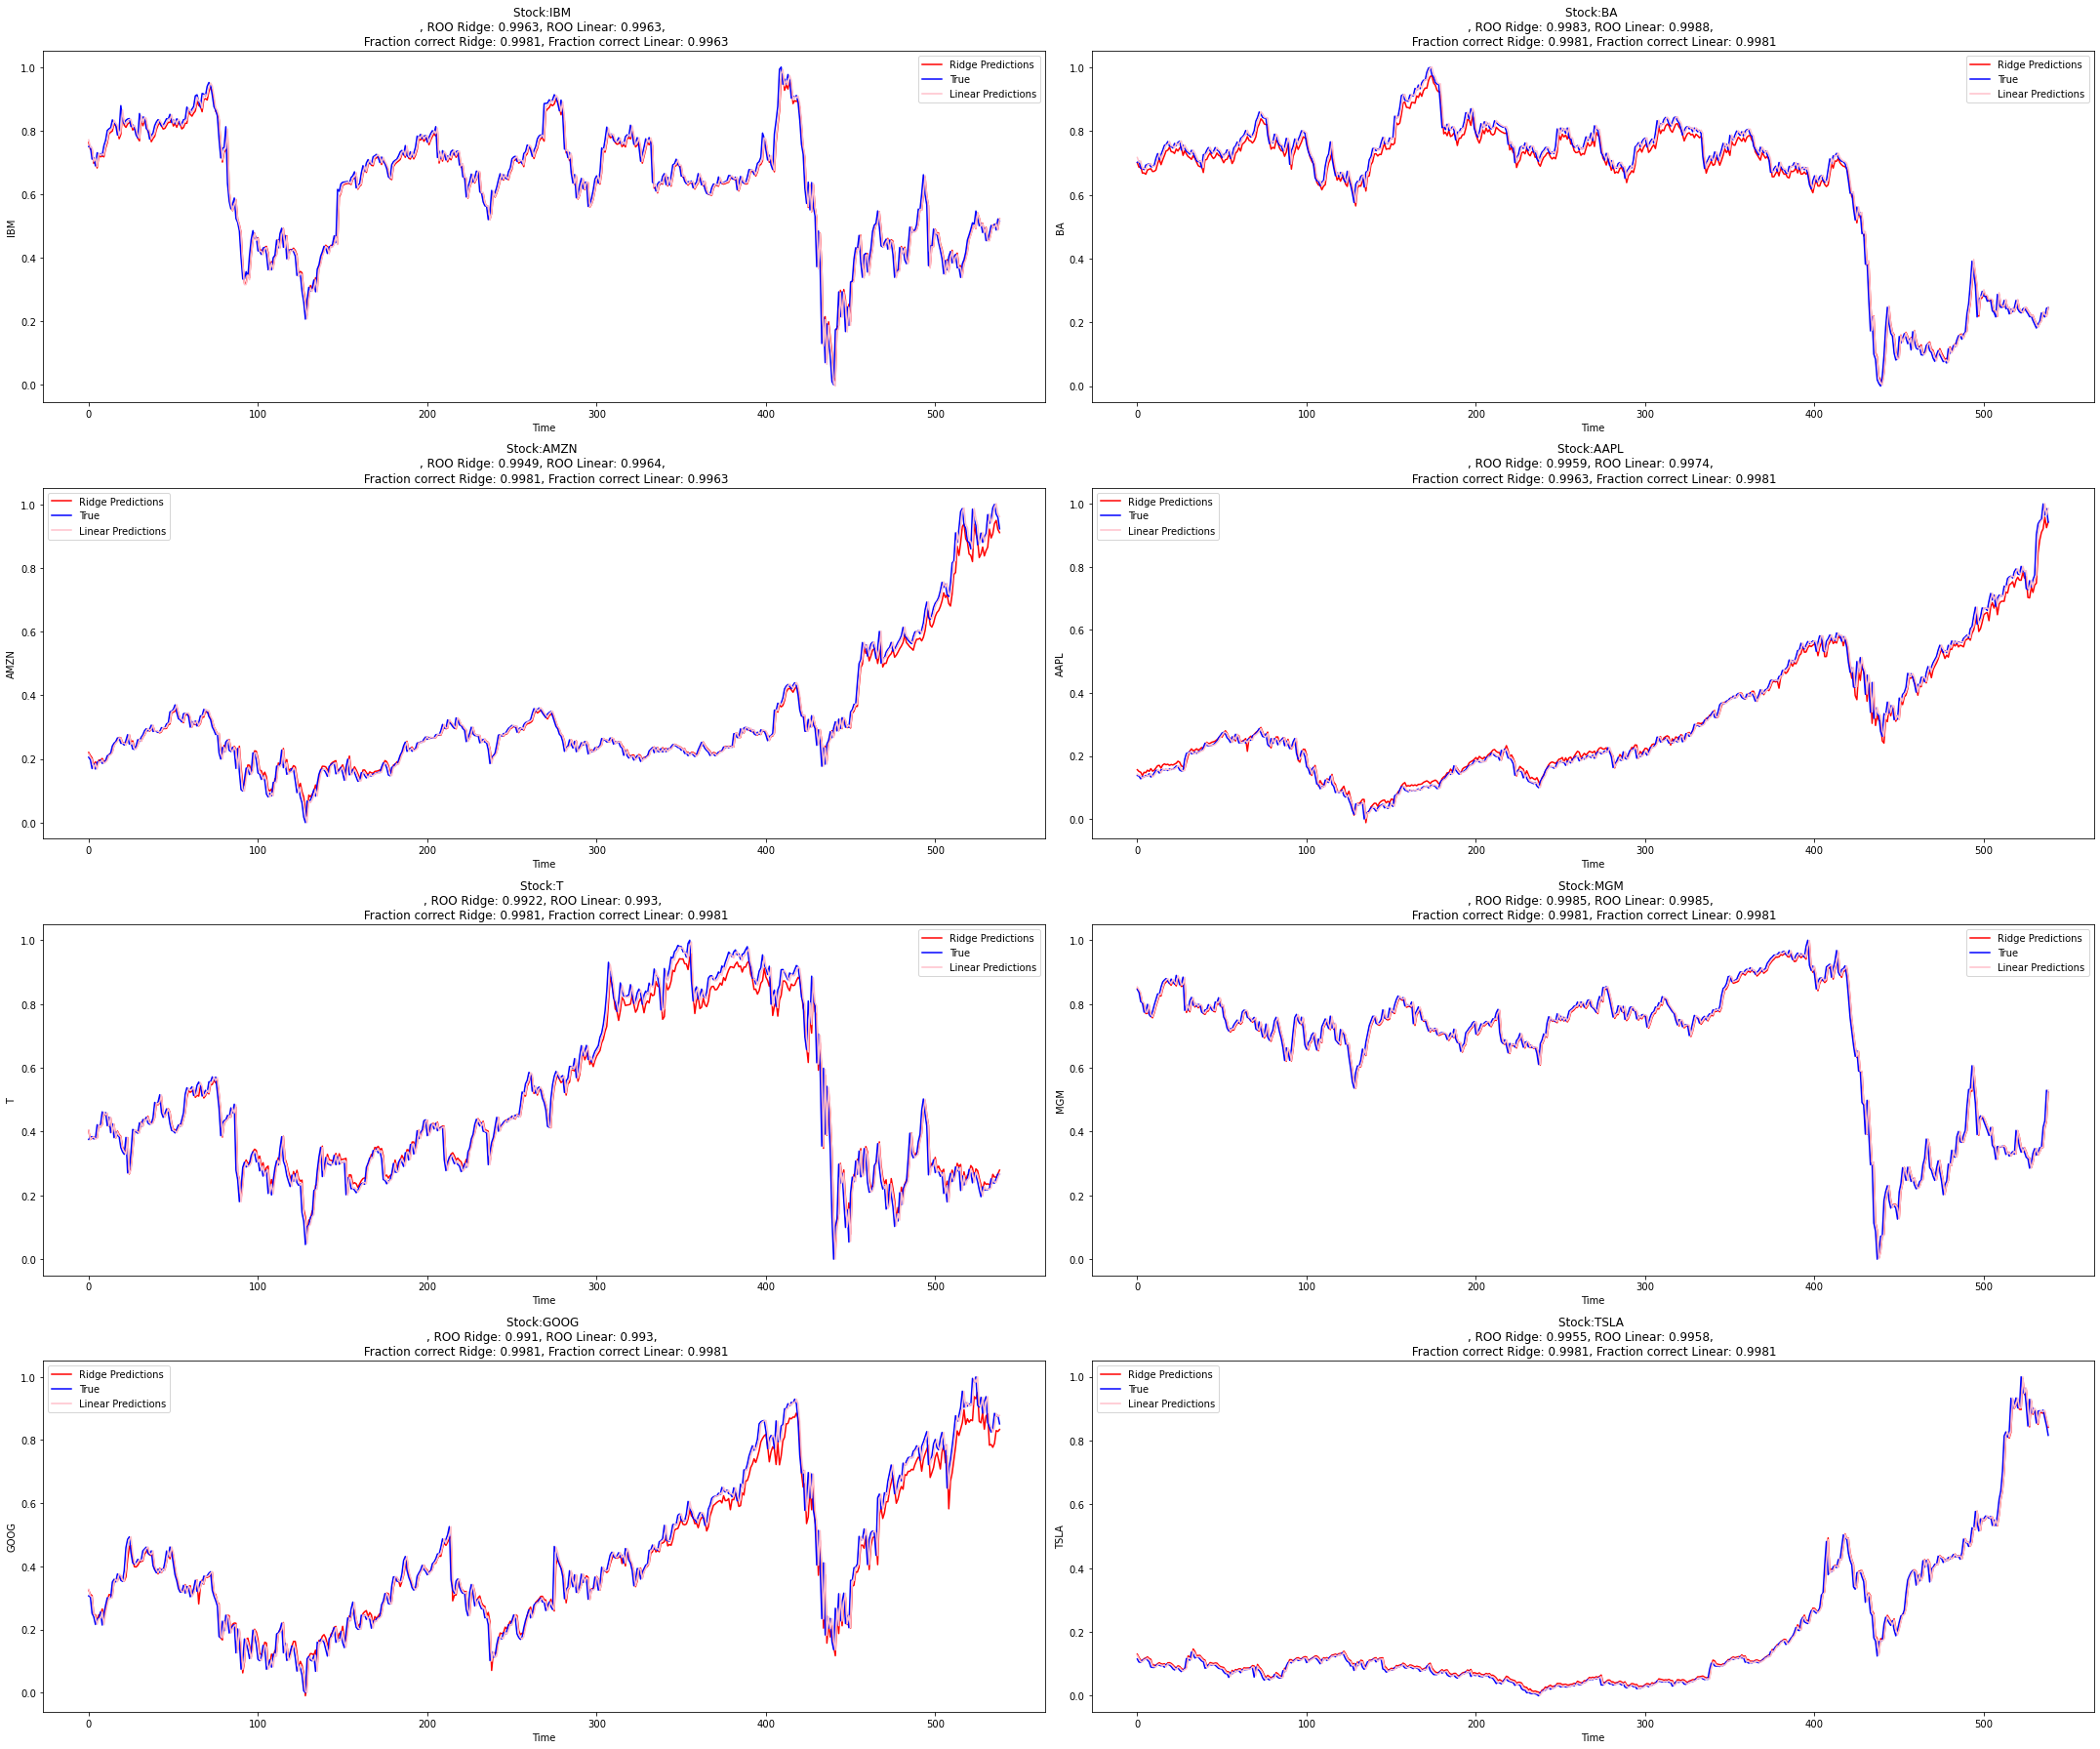

In [15]:
#Graphical comparison of Linear and Ridge Regressions
cols=np.arange(0,8).tolist()
labels=prices.columns[1:-1].tolist()
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(30,25))
for i in range(4):
    for j in range(2):
        ax=axs[i,j]
        selected=np.random.choice(cols, size=1)
        cols.remove(selected)
        selected=selected[0]
        ax.plot(ridge_preds[selected], label ='Ridge Predictions', color='red')
        ax.plot(y_test[:, selected], label ='True', color='blue')
        ax.plot(linear_predictions[selected], label ='Linear Predictions', color='pink')
        ax.set_ylabel(labels[selected])
        ax.set_xlabel('Time')
        ax.set_title (f'Stock:{labels[selected]} \n, ROO Ridge: {np.round(roos_ridge[selected], 4)}, ROO Linear: {np.round(roos_linear[selected], 4)}, \n Fraction correct Ridge: {np.round(fraction_checks_ridge[selected], 4)}, Fraction correct Linear: {np.round(fraction_checks_linear[selected], 4)}')
        ax.legend()
plt.tight_layout()
plt.show()

Overall we can see that both the ridge penalised and the non-penaliside linear model seem to perfrom pretty well in terms of their predictions for all of the stocks. Indeed, the linear model without any penalisations seems to perform the best, closely following the true data and generally we also find it presents a higher R-squared out of sample. 

## Improving the model with lags

In [14]:
def lagged_data_gen(df, lags = 1):
    '''This function generates specified amounts of lags in the passed dataframe
    input: dataframe of time series data
    return: trained scaled data with lags, corrpesonding train "unlagged" output variable
    test scaled data with lags, corresponding test "unlagged" output variable'''
    N = len(df)
    train_size = int(N*0.75)
    test = df.iloc[:, 1:][train_size:]
    train = df.iloc[:, 1:][:train_size]
    ncols = df.shape[1]-1
    
    #adding first lag
    train = pd.concat([train, train.iloc[1:, :]], axis = 1)
    test = pd.concat([test, test.iloc[1:, :]], axis = 1)
    
    if lags != 1:
        for i in range(2, lags): #looping through to add the sepcifeid amounts of lags
            train = pd.concat([train, train.iloc[i:, (i-1)*ncols:]], axis = 1) 
            test = pd.concat([test, test.iloc[i:, (i-1)*ncols:]], axis = 1)
   
    sc = MinMaxScaler(feature_range = (0.001, 1))
    train=train.iloc[lags:, :]
    test=test.iloc[lags:, :]
    train_scaled = sc.fit_transform(train)
    test_scaled = sc.fit_transform(test)
    
    #Generating response variables and removing last observtion of train
    y_train = train_scaled[lags:, :9]
    y_test = test_scaled[lags:, :9]
    train_scaled=train_scaled[:-lags,:]
    test_scaled=test_scaled[:-lags, :]
    return train_scaled, test_scaled,y_train,y_test

In [15]:
def model_evaluator(data, model, lags, n_stocks):
    '''This function evaluates the performance of a specified machine learning algorithm over predictions of time series data
    Input: data to use for the model, model to evaluate, lags, number of stocks to focus on
    Return: predicted values, returns out of sample, sign accuracy, mean squared error, test data used, lags used
    '''
    tot_preds=[]
    tot_roos=[]
    tot_fracts=[]
    mses = []
    times=np.arange(1, lags) #how many lags you want to use
    for j in times:
        predictions = []
        rooses=[]
        fraction_checks=[]
        mse = []
        tr_s, te_s, y_tr, y_te = lagged_data_gen(data, j)
        for i in range(n_stocks): #looping though stocks to consider
            indexes=[i+9*k for k in range(j)]
            indexes.append(i)
            model.fit(tr_s[:,indexes], y_tr[:,i])
            preds=model.predict(te_s[:,indexes])
            predictions.append(preds)
            rooses.append(Roos(y_te[:,i], preds))
            fraction_checks.append(Sign_check(y_te[:,i], preds))
            mse.append(mean_squared_error(y_te[:,i], preds))

        mses.append(mse)   
        tot_preds.append(predictions)
        tot_roos.append(rooses)
        tot_fracts.append(fraction_checks)
    return tot_preds, tot_roos, tot_fracts, mses, y_te, times

In [16]:
Ridge_model=Ridge(alpha=0)
app_preds, app_roos, app_fracts, app_mses, y_te, times = model_evaluator(data_absolute, Ridge_model, 8, 1)
#here we are considereing only AAPL as a stock

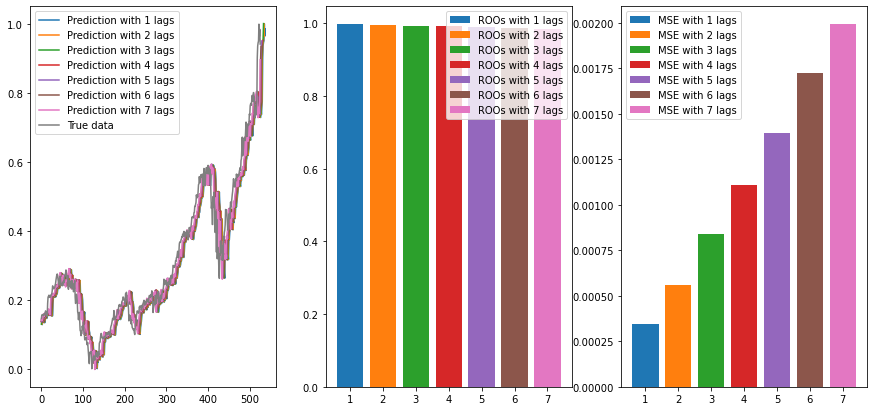

In [17]:
fig, axs = plt.subplots(ncols=3, figsize=(15,7))
ax=axs[0]
times=np.arange(1,8)
for i in range(len(app_roos)):
    ax.plot(app_preds[i][0], label=f'Prediction with {times[i]} lags')
ax.plot(y_te[:, 0], label='True data')
ax.legend()

ax=axs[1]
for i in range(len(app_roos)):
    ax.bar(times[i], app_roos[i][0], label=f'ROOs with {times[i]} lags')
ax.legend()

ax=axs[2]
for i in range(len(app_roos)):
    ax.bar(times[i], app_mses[i], label=f'MSE with {times[i]} lags')
ax.legend()

plt.show()

As it is possible to see form the graphs above, and in our examination, we initally discovere that both from a visual inspection of the line plot, and from the point of view of the returns out of sample there did not seem to be much difference associated to how many lags were used including the market. We thus looked for an alternative measure and experimented with the classc mean squared error. The latter, as visible from the rightmost graph above gave us the granularity we were looking for. Indeed, it is possible to see that, although the MSE is generally small using any amounts of lags, the less the lag the better the MSE performance. This is an interesting observation and might point at the decreased relevance on returns that are 'too old' in predicting new ones, since shocks that might have determined older returns are less impactful on helping forecast newer ones.

## Non Linear Models

In this section to try and imporve the performance of the model we tested a series of algorithms. For a sake of time and run complexity we are showing performance of models on only once stock, AAPL. Below you can see the various sections dedicated to each algorithm

### Gradient Boosting

In [18]:
#Splitting data
train =data_absolute.iloc[:int(len(data_absolute)*0.75), :]
test=data_absolute.iloc[int(len(data_absolute)*0.75):, :]
#Scaling the data
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train.iloc[:, 1:])
test_scaled =sc.fit_transform(test.iloc[:, 1:])

#Generating output variables
y_train = train_scaled[1:, :9]
y_test = test_scaled[1:, :9]
train_scaled=train_scaled[:-1,:]
test_scaled=test_scaled[:-1,:]

In [19]:
#Running a grid search for hyper parameter tuning
n_iter = 20
param_dist = {"n_estimators": np.arange(100, 1000, 10), 'max_depth':np.arange(1, 10), 'eta':np.arange(0, 0.6, 0.02)}
model = xgb.XGBRegressor()
search = BayesSearchCV(model,
                search_spaces=param_dist,
                n_iter=n_iter,
                cv=5,
                n_jobs=-1,
                random_state=1,
                verbose=False)

search.fit(train_scaled[:,[0]], y_train[:,0])
Boost_model=search.best_estimator_

In [23]:
#Generating predictions and evaluating the model
app_preds, app_roos, app_fracts, app_mses, y_te, times = model_evaluator(data_absolute, Boost_model, 8, 1)

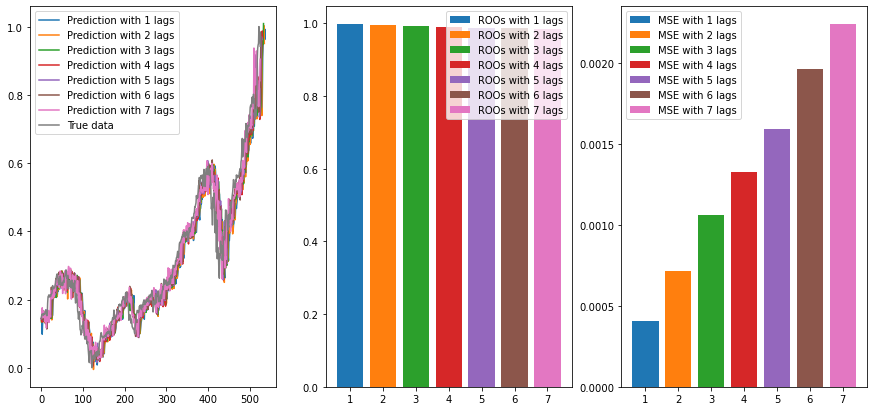

In [24]:
#Displaying the evaluation and results
fig, axs = plt.subplots(ncols=3, figsize=(15,7))
ax=axs[0]
for i in range(len(app_roos)):
    ax.plot(app_preds[i][0], label=f'Prediction with {times[i]} lags')
ax.plot(y_te[:, 0], label='True data')
ax.legend()

ax=axs[1]
for i in range(len(app_roos)):
    ax.bar(times[i], app_roos[i][0], label=f'ROOs with {times[i]} lags')
ax.legend()

ax=axs[2]
for i in range(len(app_roos)):
    ax.bar(times[i], app_mses[i], label=f'MSE with {times[i]} lags')
ax.legend()

plt.show()

Gradient boosting seems to work well in this context, having tuned the eta parameter, the number of features used and the depth that splits reached. Although performance is quite high it is not able to beat the linear regression.

### SVM

In [25]:
#Grid search with cross validationto optimize model performance
base = SVR()
    
params_grid = {'kernel':['linear', 'poly','rbf'],
                'C':np.arange(0.1,1,0.1)}
                
search = GridSearchCV(base,
                        params_grid,
                        cv=5)
                         
                         
search.fit(train_scaled[:,[0]], y_train[:,0])
svr_model =  search.best_estimator_

In [26]:
#Running and evaluating the model
app_preds, app_roos, app_fracts, app_mses, y_te, times = model_evaluator(data_absolute, svr_model, 8, 1)

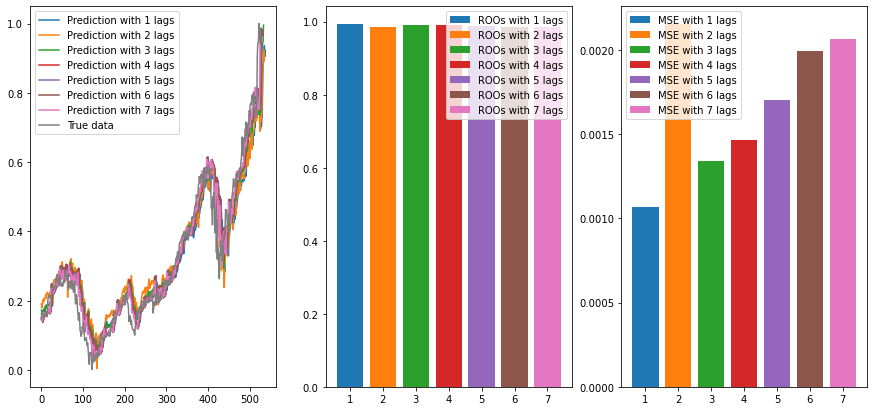

In [27]:
#Plotting
fig, axs = plt.subplots(ncols=3, figsize=(15,7))
ax=axs[0]
for i in range(len(app_roos)):
    ax.plot(app_preds[i][0], label=f'Prediction with {times[i]} lags')
ax.plot(y_te[:, 0], label='True data')
ax.legend()

ax=axs[1]
for i in range(len(app_roos)):
    ax.bar(times[i], app_roos[i][0], label=f'ROOs with {times[i]} lags')
ax.legend()

ax=axs[2]
for i in range(len(app_roos)):
    ax.bar(times[i], app_mses[i], label=f'MSE with {times[i]} lags')
ax.legend()

plt.show()

For SVR we decided to tune both the C penalty parameter and the type of kernel it was using. Indeed results, especially with one lag were quite satisfactory. However, ROOS seemed to be slightly lower than previous models, together with Mse scores at various lags being higher than all of the other models previously tested, making it an unlikely candidate to be used as part of our AI powered investment algorithm in the next section.

### Multilayered Perceptron

In [28]:
#Defining and evaluating the model
MLP_model = MLPRegressor(hidden_layer_sizes=(100,), activation="relu")
app_preds, app_roos, app_fracts, app_mses, y_te, times = model_evaluator(data_absolute, MLP_model, 8, 1)

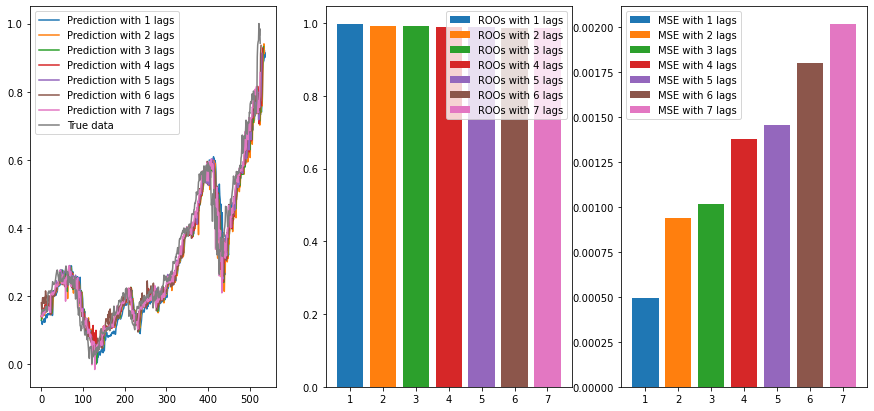

In [29]:
#Plotting
fig, axs = plt.subplots(ncols=3, figsize=(15,7))
ax=axs[0]
for i in range(len(app_roos)):
    ax.plot(app_preds[i][0], label=f'Prediction with {times[i]} lags')
ax.plot(y_te[:, 0], label='True data')
ax.legend()

ax=axs[1]
for i in range(len(app_roos)):
    ax.bar(times[i], app_roos[i][0], label=f'ROOs with {times[i]} lags')
ax.legend()

ax=axs[2]
for i in range(len(app_roos)):
    ax.bar(times[i], app_mses[i], label=f'MSE with {times[i]} lags')
ax.legend()

plt.show()

The multilayered perceptron provided very promising results. As per the indications of the research we found in class we used a very shallow arcihitecture and indeed we can see that both peromance on the ROOS and the MSE came very close to a linear model, providing good competition for its potential use in the AI powered investment algorithm.

### Bi-LSTM

In [30]:
def custom_activation(x, beta = 1):
    "Swish Activation Function, apparently works quite well with Time Series Data https://arxiv.org/abs/1710.05941"
    return (K.sigmoid(beta * x) * x)

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def bi_lstm(input_len):
        ''''This function compiles a bi-lstm model with the passed input length
        input: input shape
        returns: compiled bi-lstm model'''
        model = Sequential()
        model.add(Bidirectional(LSTM(5, input_shape=(len(input_len), 1))))
        model.add(Dense(10))
        model.add(Activation(custom_activation))
        model.add(Dense(5))
        model.add(Activation(custom_activation))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model


In [31]:
#Evaluating the model Note: here we could not use the usual function as it needed some cutstom modifications to run with this model
app_preds=[]
app_roos=[]
app_fracts=[]
times=np.arange(1, 8)
mses=[]
tf.random.set_seed(5)
for j in times:
    predictions = []
    roos=[]
    fraction_checks=[]
    tr_s, te_s, y_tr, y_te = lagged_data_gen(data_absolute, j)
    for i in range(1):
        indexes=[i+9*k for k in range(j+1)]
        indexes.append(i)
        bilstm = bi_lstm(indexes)
        tr_s=tr_s[:, indexes]
        tr_s = tr_s.reshape(tr_s.shape[0], tr_s.shape[1], 1)
        bilstm.fit(tr_s, y_tr[:, i], epochs=20, batch_size=10, verbose=0)
        
        preds=bilstm.predict(te_s[:, indexes])
        preds=preds.reshape(preds.shape[0])
        predictions.append(preds)
        roos.append(Roos(y_te[:,i], preds))
        fraction_checks.append(Sign_check(y_te[:,i], preds))
        mses.append(mean_squared_error(y_te[:, i], preds))
    app_preds.append(predictions)
    app_roos.append(roos)
    app_fracts.append(fraction_checks)

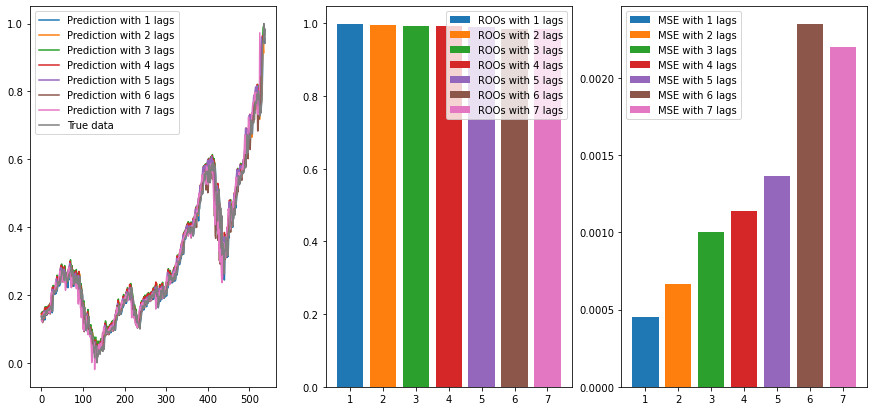

In [32]:
fig, axs = plt.subplots(ncols=3, figsize=(15,7))
ax=axs[0]
for i in range(len(app_roos)):
    ax.plot(app_preds[i][0], label=f'Prediction with {times[i]} lags')
ax.plot(y_test[:, 0], label='True data')
ax.legend()

ax=axs[1]
for i in range(len(app_roos)):
    ax.bar(times[i], app_roos[i][0], label=f'ROOs with {times[i]} lags')
ax.legend()

ax=axs[2]
for i in range(len(app_roos)):
    ax.bar(times[i], mses[i], label=f'MSE with {times[i]} lags')
ax.legend()

plt.show()

Finally we tried a bi-lstm utilising only one bidirectional LSTM layer and a few dense ones to keep the arcithecture as shallow as possible. Indeed it worked wwell showing pormissing results. In terms of neural networks however the Multilayered percepotron performed better, poettnially due to it greater closeness in term of operations to what the best model, the linear one, did.

## Performance of the AI-driven portfolio
We decided to use the linear model with only 1 lag on the returns and 1 lag on the volume as it is the one with the lowest test MSE among all the models we tested (together with performing well also in terms of ROOS). For the sake of time, we assume that it is the best model for all stocks.

In [33]:
#Utilising returns data
changes_all.head(2)

,Date,AAPL_ret,BA_ret,T_ret,MGM_ret,AMZN_ret,IBM_ret,TSLA_ret,GOOG_ret,sp500_ret,AAPL_vol,BA_vol,T_vol,MGM_vol,AMZN_vol,IBM_vol,TSLA_vol,GOOG_vol,sp500_vol
0,2012-01-13,-0.003749,-0.012051,-0.001660,0.018137,0.014153,-0.007699,-0.193274,-0.007385,-0.004948,0.063195,0.179591,-0.166508,-0.070946,-0.117401,-0.232786,6.542027,0.230422,-0.081475
1,2012-01-17,0.011648,0.008579,0.005986,-0.008097,0.018159,0.004689,0.167179,0.005744,0.003553,0.074664,-0.202754,0.063511,-0.068645,0.187441,0.137180,-0.154316,-0.172503,0.086156


In [34]:
#Splitting dataset in test and train
train =changes_all.iloc[:int(len(data_absolute)*0.75), :]
test=changes_all.iloc[int(len(data_absolute)*0.75):, :]

y_train = train.iloc[:, 1:].to_numpy()[1:, :9]
y_test = test.iloc[:, 1:].to_numpy()[1:, :9]
train_scaled=train.iloc[:, 1:].to_numpy()[:-1,:]
test_scaled=test.iloc[:, 1:].to_numpy()[:-1,:]

In [35]:
#Defining model (Ridge worked best from our tests above)
linear_model =Ridge(alpha=0)
linear_model.fit(train_scaled, y_train)

Ridge(alpha=0)

In [36]:
#Generating portfolio values for our AI powered investor
labels = prices.columns[1:-1] 
def portfolio_generator(train,y_train, test, model, proportional = True):
    rets_portfolio=[]

    for t in tqdm(range(test.shape[0]-1)): #looping trhough each testing date
        return_dict=dict()
        for stock in range(len(labels)): #looping through stocks to make predictions
            linear_model =model
            linear_model.fit(train[:,[stock, stock+9]], y_train[:,stock])
            #storing the predictions in a dictionary
            return_dict[labels[stock]]=linear_model.predict(test[t, [stock, stock+9]].reshape(1,2))
            
        #Creating a dictionary with keys the stock symbol in the same order as they are present in the test matrix    
        d1 = dict()
        for i in labels:
            d1[i]=0
        
        top4=Counter(return_dict).most_common(4) #identifying top 4 stocks by return
        rets4=np.array([i[1][0] for i in top4]) #extracting only value
        stocks4=[i[0] for i in top4] #extracting only the stocm name
        
        if proportional == True:
            weights=np.array([i/np.sum(rets4) for i in rets4]) #generating weights proportional to expected return in next period
        else:
            weights=np.array([1/len(rets4) for i in rets4]) #generating weights 
        
        for i in range(len(stocks4)):
            d1[stocks4[i]]=weights[i] #updating the dictionary with the just computed weights
            
        weights_correct=np.array([i for i in d1.values()]) #assigning weight to appropriate stock
        ret_portfolio_daily=np.dot(test[t+1, :8], weights_correct) #computing daily return
        rets_portfolio.append(ret_portfolio_daily)
    return rets_portfolio

In [37]:
def compute_evolution(rets, initial_investment=100):
    '''This function computes the evolution of the value of an initial investment over the period of the passed data
    input: data with returns, value of initial investment
    return: list with values of the initail investment across the examined period '''
    investment_evolution=[initial_investment]
    for i in rets:
        investment_evolution.append(investment_evolution[-1]*(1+i))
    return investment_evolution

In [38]:
#Generating evolutions of our initial investment for the market (here we used sp500 as a proxy) and for our AI portfolio

#Proportional Weights
rets_portfolio = portfolio_generator(train_scaled, y_train, test_scaled, Ridge(alpha = 0))
investment_evolution = compute_evolution(rets_portfolio, initial_investment=100)
#Equal Weights
equal_rets =portfolio_generator(train_scaled, y_train, test_scaled, Ridge(alpha = 0), proportional = False)
equal_weights_investment = compute_evolution(equal_rets, initial_investment=100)
#Market Evolution
market = changes_all['sp500_ret'].to_numpy()[train_scaled.shape[0]:]
market_evolution = compute_evolution(market, initial_investment=100)

100%|███████████████████████████████████████████████████████████████████████████████| 537/537 [00:02<00:00, 198.93it/s]


Investment value at the end of test AI (proportional weights): 216.77
Percantage Increase (proportional weights):  116.77 %
Investment value at the end of test AI (equal weights): 267.95
Percantage Increase (equal weights):  167.95 %
Investment value at the end of test S&P500: 120.67
Percantage Increase (SP500):  20.67 %


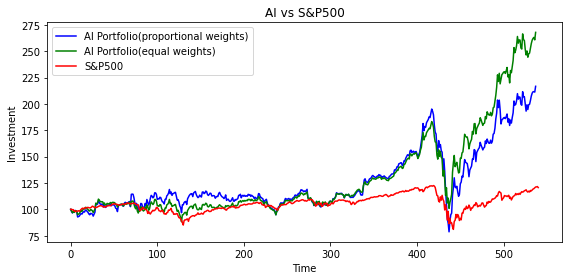

In [39]:
print('Investment value at the end of test AI (proportional weights):', np.round(investment_evolution[-1],2))
print('Percantage Increase (proportional weights): ', np.round(investment_evolution[-1]-100, 2),'%')
print('Investment value at the end of test AI (equal weights):', np.round(equal_weights_investment[-1],2))
print('Percantage Increase (equal weights): ', np.round(equal_weights_investment[-1]-100, 2),'%')
print('Investment value at the end of test S&P500:', np.round(market_evolution[-1],2))
print('Percantage Increase (SP500): ', np.round((market_evolution[-1]-100),2),'%' )
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(investment_evolution, color='blue', label='AI Portfolio(proportional weights)')
ax.plot(equal_weights_investment, color='green', label='AI Portfolio(equal weights)')
ax.plot(market_evolution, color='red', label='S&P500')
ax.set_title('AI vs S&P500')
ax.set_xlabel('Time')
ax.set_ylabel('Investment')
ax.legend()
plt.tight_layout()
plt.show()

As we can see we are consistently beating our proxy for the market (sp500), suggesting that indeed our model is working well in predicting which stocks will perform better, and thus should be in our portfolio, from day to day. We more than duplicate the initial money invested. Additionally, it is worth noting how the equally weighted portfolio performs better than the proportional one. This result can be explained through the greater level of diversification achieved each period by the equally weighted portfolio.

### AI Portfolio v.s. 1000 randomly generated portfolios

In [40]:
#Generating the timeseries of the evolution of the investment for the 1000 random portfolios
evolutions=[]
for i in range(1000):
    wgts = np.random.uniform(0,1,size=8) #generating ranodm weights
    wgts /= np.sum(wgts) #making sure they are between 0 and 1
    portfolio = np.dot(test_scaled[:,:8], wgts) #calculating portfolio value
    evolutions.append(compute_evolution(portfolio))

Investment value at the end of test AI: 216.77
Percantage Increase AI:  116.77 %
Investment value at the end of test AI (equal weights): 267.95
Percantage Increase (equal weights):  167.95 %
Mean Investment value at the end of test 1000 portfolios: 146.02
Percantage Increase simulated portfolios:  46.02000000000001 %


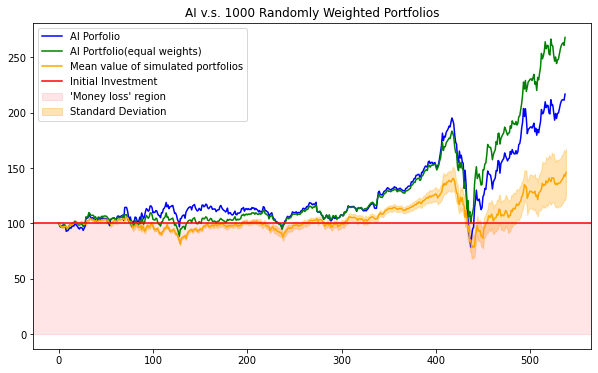

In [41]:
#Displaying performances
print('Investment value at the end of test AI:', np.round(investment_evolution[-1],2))
print('Percantage Increase AI: ', np.round(investment_evolution[-1]-100, 2),'%')
print('Investment value at the end of test AI (equal weights):', np.round(equal_weights_investment[-1],2))
print('Percantage Increase (equal weights): ', np.round(equal_weights_investment[-1]-100, 2),'%')

sim_port_mean = np.round(np.mean([i[-1] for i in evolutions]),2)
print('Mean Investment value at the end of test 1000 portfolios:', sim_port_mean)
print('Percantage Increase simulated portfolios: ',sim_port_mean-100, '%' )


fig, ax =plt.subplots(figsize=(10,6))

#AI portfolio
ax.plot(investment_evolution, color='blue', label='AI Porfolio')
ax.plot(equal_weights_investment, color='green', label='AI Portfolio(equal weights)')
#Mean and std fo simulated portfolios
ax.plot(np.mean(evolutions,axis=0),label='Mean value of simulated portfolios',color='orange')
ax.fill_between(np.arange(539),np.mean(evolutions,axis=0)-np.std(evolutions,axis=0),np.mean(evolutions,axis=0)+np.std(evolutions,axis=0),color='orange',alpha=0.3, label='Standard Deviation')

#Initial investment threshold
ax.axhline(100, color='red', label='Initial Investment')
ax.axhspan(ymin = 0, ymax = 100,color = 'red', alpha = 0.1, label="'Money loss' region")
ax.legend()
ax.set_title('AI v.s. 1000 Randomly Weighted Portfolios')
plt.show()

The plot above show us some interesting results. Indeed, it seems that we not only beat the market but also work well above the 1000 portfolios we simulates. Indeed we do have some periods whereby if we stopped investing we would make some losses, but those are a lot more contained compared to the ones made by the ranodm portfolios. In addition, at the end of the test period we also achieve greatly higher gains compared to the simulated portfolio, once again doubling our initial investment compared to increasing them than half on average.

It is worth noting that the average ending value of the 1000 random portfolios is higher than that of the market. An explanation for this comes from the fact that the stocks on which data is available are performing extremely well over the period considered. Therefore, such result stems from selection bias in the construction of the dataset.

### AI Portfolio with transacton fees

#### Not optimised transactions
In this portfolio, as asked by the task, we simply apply commission every time, without optimizing the number of transactions we actually carry out. In the iteration after we will optimise this element.

N.B. In this section we are using an equally weighted portfolio since the performance observed before is higher than that of the proportional one

In [42]:
#Generating portfolio values for our AI powered investor
start_inv = 100
portfolio_value =[start_inv]
labels = prices.columns[1:-1] 
rets_portfolio=[]
rets_for_commission = []
stock_history = []
stock_name_index = {labels[i]:i for i in range(len(labels))}

for t in tqdm(range(test_scaled.shape[0]-1)): #looping though each date
    return_dict=dict()
    for stock in range(len(labels)): #looping though stocks to make predictions
        linear_model =Ridge(alpha=0)
        linear_model.fit(train_scaled[:,[stock, stock+9]], y_train[:,stock])
        #storing predicted returns
        return_dict[labels[stock]]=linear_model.predict(test_scaled[t, [stock, stock+9]].reshape(1,2))
        
    #Creating a dictionary with keys the stock symbol in the same order as they are present in the test matrix 
    d1 = dict()
    for i in labels:
        d1[i]=0
    
    top4=Counter(return_dict).most_common(4) #identifying top 4 stocks by return
    rets4=np.array([i[1][0] for i in top4]) #extracting only value
    stocks4=set(i[0] for i in top4) #extracting only the stock name
    stock_history.append(stocks4)
    if t==0:
        changed = stocks4 #identify number of stocks that need to be purchased
    if t>=1:
        changed = stock_history[-2].difference(stocks4) #identify number of stocks that need to be purchased
    
   
    weights = np.array([0.25 for i in rets4]) #equal weights
    
    stocks4 = list(stocks4)
    for i in range(len(stocks4)):
        d1[stocks4[i]]=weights[i] #updating the weights of the stocks in which to invest

        
    weights_correct=np.array([i for i in d1.values()]) #assigning weight to appropriate stock
    ret_portfolio_daily=np.dot(test_scaled[t+1, :8], weights_correct)
    rets_portfolio.append(ret_portfolio_daily)

    commission_cost = portfolio_value[-1]*0.03*(len(changed)*0.25) #computing the commission cost based on the number of transactions
    port = portfolio_value[-1]-commission_cost #updating the portfolio value due to commissions
    port = port*(1+ret_portfolio_daily)
    portfolio_value.append(port)

100%|███████████████████████████████████████████████████████████████████████████████| 537/537 [00:03<00:00, 177.61it/s]


#### Optimised Transactions
In this portfolio we decided to optimise the number of transactions we do to try and decrease the costs associated to buying/selling costs. What we do is essentially understand whether changing the stocks in our current portfolio with the next top 4 predicted stocks is convenient. If the best performing stocks of the next time period gives us worst monetary returns than the stock that performs worst in our current portfolio then we do not change stocks and save money on the commision cost.

In [45]:
#Generating portfolio values for our AI powered investor
from multiprocessing import current_process


start_inv = 100
portfolio_value_intelligent=[start_inv]
labels = prices.columns[1:-1] 
rets_portfolio=[]
rets_for_commission = []
stock_history = []
stock_name_index = {labels[i]:i for i in range(len(labels))}

for t in tqdm(range(test_scaled.shape[0]-1)): #looping though each date
    return_dict=dict()
    for stock in range(len(labels)): #looping though stocks to make predictions
        linear_model =Ridge(alpha=0)
        linear_model.fit(train_scaled[:,[stock, stock+9]], y_train[:,stock])
        #storing predicted returns
        return_dict[labels[stock]]=linear_model.predict(test_scaled[t, [stock, stock+9]].reshape(1,2))
    
    #Creating a dictionary with keys the stock symbol in the same order as they are present in the test matrix 
    d1 = dict()
    for i in labels:
        d1[i]=0
    
    top4=Counter(return_dict).most_common(4) #identifying top 4 stocks by return
    rets4=np.array([i[1][0] for i in top4]) #extracting only value
    stocks4=set(i[0] for i in top4) #extracting only the stock name
    
    if t==0:
        stock_history.append(stocks4)
        changed = stocks4 #number of new stocks
        weights = np.array([0.25 for i in rets4])
        stocks4 = list(stocks4)
        #updating weights
        for i in range(len(stocks4)):
            d1[stocks4[i]]=weights[i]

        changed = stocks4

        weights_correct=np.array([i for i in d1.values()]) #assigning weight to appropriate stock
        ret_portfolio_daily=np.dot(test_scaled[t+1, :8], weights_correct)
        rets_portfolio.append(ret_portfolio_daily)

        commission_cost = portfolio_value_intelligent[-1]*0.03*(len(changed)*0.25) #computing transaction costs
        port = portfolio_value_intelligent[-1]-commission_cost
        port = port*(1+ret_portfolio_daily) #updating portfolio value
        portfolio_value_intelligent.append(port)

    else:
    # 1.we rank the stocks we have now by return (use retur_dict)
    # 2.we rank the stocks we should have tomorrow by return
    # 3.we take the worst stock from today, calculate its  monetary return tomorrow and subtract the monetary return of the best changed stock of tomorrow net of commission
    # 4. if this difference is negative then we replace the worst stock with this new stock
    # 5. else we don't update the portfolio 
    # 6. iterate
    
        current_stocks = stock_history[-1]
        current_stocks = {k: return_dict[k] for k in current_stocks}
        #sorting the stocks in the current portfolio based on their expected return
        current_stocks = {k: v for k, v in sorted(current_stocks.items(), key=lambda item: item[1],reverse = True)}
        #sorting the dictionary of all expected returns
        return_dict = {k: v for k, v in sorted(return_dict.items(), key=lambda item: item[1],reverse = True)}
        for k,v in return_dict.items():
            if i in current_stocks: #we already own the stock, so no changes to the portfolio
                continue
            else:
                #computing the difference between expected return of the least performing stock in the portfolio
                #with the expected return of the best performing stock not in the portfolio by taking into account commissions
                diff = (portfolio_value_intelligent[-1]*current_stocks.values()[-1]*0-25)- (v*portfolio_value_intelligent[-1]*0.25*0.97)
                if diff<=0: #stock not in portfolio performs better than the one in the portfolio
                    del current_stocks[current_stocks.keys()[-1]] #eliminate low performing stock
                    current_stocks[k] = v #updating dictionary
                    #sorting dictionary
                    current_stocks = {k: v for k, v in sorted(current_stocks.items(), key=lambda item: item[1],reverse = True)}
                else:
                    #we stop the loop
                    break

        stock_history.append(set(current_stocks.keys()))
    
        weights = np.array([0.25 for i in current_stocks.values()])
    
        current_stocks = list(current_stocks.keys())

        for i in range(len(current_stocks)):
            d1[current_stocks[i]]=weights[i] 

        changed = stock_history[-2].difference(stock_history[-1]) #number of new stocks

        weights_correct=np.array([i for i in d1.values()]) #assigning weight to appropriate stock
        ret_portfolio_daily=np.dot(test_scaled[t+1, :8], weights_correct)
        rets_portfolio.append(ret_portfolio_daily)

        commission_cost = portfolio_value_intelligent[-1]*0.03*(len(changed)*0.25)
        port = portfolio_value_intelligent[-1]-commission_cost
        port = port*(1+ret_portfolio_daily) #updating portfolio value
        portfolio_value_intelligent.append(port)

100%|███████████████████████████████████████████████████████████████████████████████| 537/537 [00:03<00:00, 176.09it/s]


Investment value at the end of test Optimised AI: 181.8
Percantage Change Optimised AI:  81.8 %
Investment value at the end of test Not Optimised AI: 1.62
Percantage Change Not Optimised AI:  -98.38 %
Investment value at the end of test S&P500: 120.67
Percantage Change market:  20.67 %


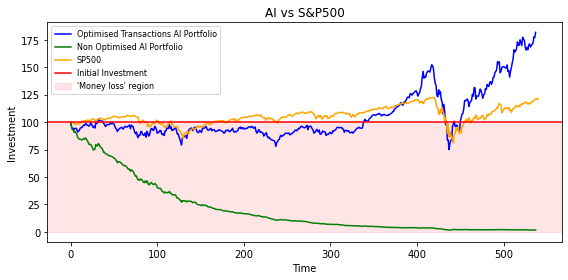

In [46]:
print('Investment value at the end of test Optimised AI:', np.round(portfolio_value_intelligent[-1],2))
print('Percantage Change Optimised AI: ', np.round(portfolio_value_intelligent[-1]-100, 2),'%')
print('Investment value at the end of test Not Optimised AI:', np.round(portfolio_value[-1],2))
print('Percantage Change Not Optimised AI: ', np.round(portfolio_value[-1]-100, 2),'%')
print('Investment value at the end of test S&P500:', np.round(market_evolution[-1],2))
print('Percantage Change market: ', np.round((market_evolution[-1]-100),2),'%' )
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(portfolio_value_intelligent, color='blue', label='Optimised Transactions AI Portfolio')
ax.plot(portfolio_value, color='green', label='Non Optimised AI Portfolio')
ax.plot(market_evolution, color='orange', label='SP500')
ax.axhline(100, color='red', label='Initial Investment')
ax.axhspan(ymin = 0, ymax = 100,color = 'red', alpha = 0.1, label="'Money loss' region")

ax.set_title('AI vs S&P500')
ax.set_xlabel('Time')
ax.set_ylabel('Investment')
ax.legend(prop= {'size':8})
plt.tight_layout()
plt.show()

As we can see from the graph, transaction costs have a huge impact on the performance of the AI portfolio. In particular, if we trade disregarding their costs, the value of the portfolio quickly declines. Instead, by considering the transaction costs in each trade, we are still able to perform better than the market. Importantly, the overall return is quite diminished compared to the previous scenario featuring no transaction costs.